In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 

solverpath_exe = 'C:\\Users\\Yuri Muniz\\OneDrive\\Documentos\\solvers\\glpk-4.65\\w64\\glpsol'

# Smallest tree without loop

Objective: minimize the total lenght of connections between N nodes. All nodes must be connected to each other in the tree. In order to solve this problem, you can think that one of the nodes is a production plant that shall provide products to a certain number of facilities (the other nodes) and need to minimize the effort required for doing that. Each facility must receive exactly one box and can also send products to other faciities without an increase in cost. Mathematically, we need to minimize

$$\sum_{ij}U_{ij}D_{ij},$$

where $U_{ij}$ is a binary variable that indicates if there is a connection between two nodes or not and

$$D_{ij} = (x_i - x_j)^2 + (y_i - y_j)^2$$

is the distance between two nodes. We must also guarantee that the production plant must ship all products and should not receive anything back:

$$\sum_j flow_{1j} - flow_{j1} = N - 1,$$

where $flow_{ij}$ is the number of products sent from node $i$ to node $j$, $1$ is the index of the production plant, and $N$ is the total number of nodes. For all facilities, we must assure that it send any extra product to another facility (keep only one product):

$$\sum_j flow_{ij} - flow_{ji} = -1.$$

Finally, we must connect $U_{ij}$ and $flow_{ji}$ by writing that $U_{ij} \neq 0$ if node $i$ receives products from node $j$:

$$U_{ij} \ge flow_{ji}/N.$$



In [2]:
# Defining abstract model, parameters and variables
model = AbstractModel()
model.N =Param(mutable=True,default=8) 
model.i = RangeSet(1,model.N)
model.U = Var(model.i,model.i, within=Binary, initialize = 1)
model.flow = Var(model.i,model.i, within=NonNegativeReals)
model.OF = Var(within=NonNegativeReals,initialize=5)

def initval(model,i):
    return random.uniform(0,1)
model.Xloc=Param(model.i,  within=NonNegativeReals, initialize=initval,mutable=True)
model.Yloc=Param(model.i,  within=NonNegativeReals, initialize=initval, mutable=True)

def Rule_D(model,i,j):
    return sqrt((model.Xloc[i]-model.Xloc[j])**2+(model.Yloc[i]-model.Yloc[j])**2)
model.D=Param(model.i,model.i,  within=NonNegativeReals,initialize=Rule_D, mutable=True)

# Constraints
def rule_C1(model,i):
    if i==1:
        return model.N - 1 == sum(model.flow[i,j]-model.flow[j,i] if i!=j else 0 for j in model.i)
    else:
        return        -1==sum(model.flow[i,j]-model.flow[j,i] if i!=j else 0 for j in model.i)
model.C1   = Constraint(model.i,rule=rule_C1)

def rule_C2(model,i,j):
    return model.U[i,j]*model.N >= model.flow[j,i]
model.C2   = Constraint(model.i,model.i,rule=rule_C2)

# To define the objective we need this trick (cannot sum without it)
def objective(model):
    return model.OF == sum(model.U[r,c]*model.D[r,c] for r in model.i for c in model.i)
model.objC = Constraint(rule = objective)

model.obj1 = Objective(expr=model.OF, sense=minimize)

In [3]:
opt = SolverFactory('glpk', executable=solverpath_exe)
model.N=10
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.obj1))

OF=  2.36734212380186


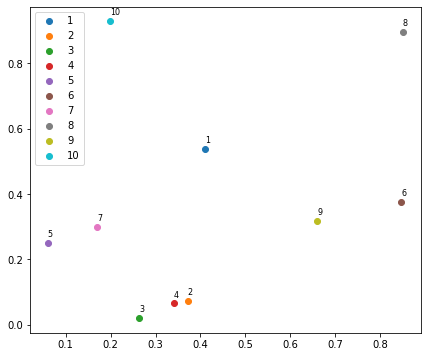

In [4]:
fig = plt.figure(figsize=(7,6))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i))
    plt.text(value(instance.Xloc[i]),0.02+value(instance.Yloc[i]), str(i), fontsize=8)
plt.legend()

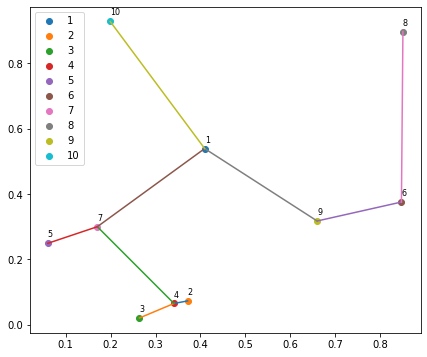

In [6]:
fig = plt.figure(figsize=(7,6))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i))
    plt.text(value(instance.Xloc[i]),0.02+value(instance.Yloc[i]), str(i), fontsize=8)
plt.legend()
for i in instance.i:
    for j in instance.i:
        if i!=j:
            if value(instance.U[i,j])==1:
                plt.plot([value(instance.Xloc[i]),value(instance.Xloc[j])],[value(instance.Yloc[i]),value(instance.Yloc[j])])
                

# Conference allocation

Objective: choose which $N_c < N$ cities should hold a conference in order to minimize the travelling distances from other cities. The objective function is the same as in the previous problem, namely, 

$$\sum_{ij}U_{ij}D_{ij},$$

where $U_{ij}$ is a binary variable that indicates if there is a connection between two nodes or not and

$$D_{ij} = (x_i - x_j)^2 + (y_i - y_j)^2$$

is the distance between two nodes. However, now we must guarantee that each city is connected to only one host city. To do so, we define $Uc_{i}$ as being a binary value which is $1$ if the city hosts the conference and $0$ otherwise. Hence

$$U_{ij} <= Uc_{i} + Uc_{j}.$$

Since there are only $N_c$ host cities, we have

$$\sum_i Uc_i = N_c.$$

Finally, each city must be connected to at least one other city (the host cities shall be connected to all near cities and the non-host cities must be connected to the host city). The corresponding constraint is

$$\sum_j U_{ij} \ge 1.$$

In [30]:
# Defining abstract model, parameters and variables
model = AbstractModel()
model.N =Param(mutable=True,default=10)
model.Nc =Param(mutable=True,default=3) 
model.i = RangeSet(1,model.N)
model.U = Var(model.i,model.i, within=Binary, initialize = 1)
model.Uc = Var(model.i, within=Binary,initialize=0)
model.OF = Var(within=NonNegativeReals,initialize=5)

def initval(model,i):
    return random.uniform(0,1)
model.Xloc=Param(model.i,  within=NonNegativeReals, initialize=initval,mutable=True)
model.Yloc=Param(model.i,  within=NonNegativeReals, initialize=initval, mutable=True)

def Rule_D(model,i,j):
    return sqrt((model.Xloc[i]-model.Xloc[j])**2+(model.Yloc[i]-model.Yloc[j])**2)
model.D=Param(model.i,model.i,  within=NonNegativeReals,initialize=Rule_D, mutable=True)

# Constraints
def rule_C1(model,i):
    return sum(model.U[i,j] if i!=j else 0 for j in model.i) >= 1
model.C1   = Constraint(model.i,rule=rule_C1)

def rule_C2(model):
    return sum(model.Uc[j] for j in model.i) == model.Nc
model.C2   = Constraint(rule=rule_C2)

def rule_C3(model,i,j):
    return model.U[i,j] <= model.Uc[i] + model.Uc[j]
model.C3   = Constraint(model.i,model.i,rule=rule_C3)

# To define the objective we need this trick (cannot sum without it)
def objective(model):
    return model.OF == sum(model.U[r,c]*model.D[r,c] for r in model.i for c in model.i)
model.objC = Constraint(rule = objective)

model.obj1 = Objective(expr=model.OF, sense=minimize)

In [37]:
opt = SolverFactory('glpk', executable=solverpath_exe)
model.N=50
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.obj1))

OF=  11.990963868969


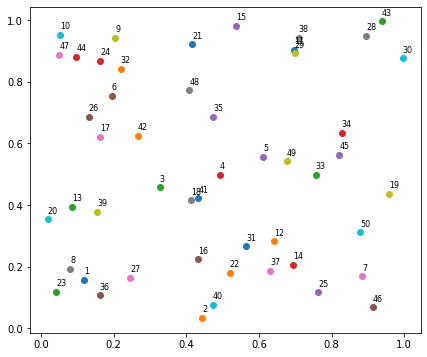

In [40]:
fig = plt.figure(figsize=(7,6))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i))
    plt.text(value(instance.Xloc[i]),0.02+value(instance.Yloc[i]), str(i), fontsize=8)

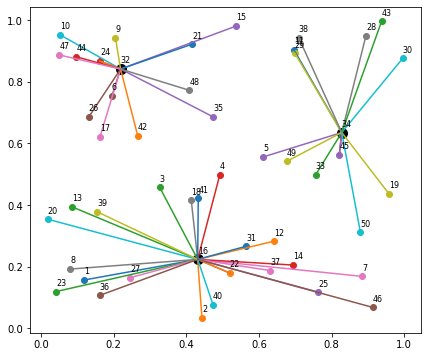

In [41]:
fig = plt.figure(figsize=(7,6))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i))
    plt.text(value(instance.Xloc[i]),0.02+value(instance.Yloc[i]), str(i), fontsize=8)
    if value(instance.Uc[i]) == 1:
        plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]), color = 'black', s = 100)
for i in instance.i:
    for j in instance.i:
        if i!=j:
            if value(instance.U[i,j])==1:
                plt.plot([value(instance.Xloc[i]),value(instance.Xloc[j])],[value(instance.Yloc[i]),value(instance.Yloc[j])])